# **California District Housing Values: Model Building**

## **About the data**

### Data collection

Median house prices for *California districts* derived from the 1990 census.  The [dataset](https://www.kaggle.com/datasets/harrywang/housing?resource=download), derived from research by ***Pace, R. Kelley, and Ronald Barry in their 1997 paper "Sparse Spatial Autoregressions,"*** offers a historical lens through which we can understand and project housing market trends. Each observation represents a block group—a small geographical unit that serves as the foundation for building a model with significant practical applications. The block group can be defined as a district for easier interpretation.

### Feature Information

1. **longitude**: A measure of how far west a house is; a higher value is farther west

2. **latitude**: A measure of how far north a house is; a higher value is farther north

3. **housingMedianAge**: Median age of a house within a block; a lower number is a newer building

4. **totalRooms**: Total number of rooms within a block

5. **totalBedrooms**: Total number of bedrooms within a block

6. **population**: Total number of people residing within a block

7. **households**: Total number of households, a group of people residing within a home unit, for a block

8. **medianIncome**: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. **medianHouseValue** ***(Target Variable)***: Median house value for households within a block (measured in US Dollars)

10. **oceanProximity**: Location of the house w.r.t ocean/sea. They have the following five categories: 'NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN' and 'ISLAND'.

### Import Useful Libraries and data

In [51]:
# data manipulation and numerical calculations
import pandas as pd
import numpy as np
pd.set_option('display.width', 150) # set output width for dataframes
import random as rnd

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [52]:
# read dataset
housing_data = pd.read_csv('data/housing.csv')

In [53]:
# train-test split
from sklearn.model_selection import train_test_split

In [54]:
train_df, test_df = train_test_split(housing_data, test_size=0.2, random_state= 42)

In [55]:
print(f'The training data of independent contains {train_df.shape[0]} observations and {train_df.shape[1]} variables')
print(f'The testing data contains {test_df.shape[0]} observations and {test_df.shape[1]} variables')

The training data of independent contains 16512 observations and 10 variables
The testing data contains 4128 observations and 10 variables


In [56]:
# Separate features for easier use in analysis
numerical_features = ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']
categorical_features = ["ocean_proximity"]
target = "median_house_value"

## Feature Engineering

As each observation of the housing data denotes a single district of california, we can do feature engineering for more meaningful features.

The following features could be engineered:
1. **Longitude** & **Latitude**
   - **Interaction Term**: Create an interaction term between *longitude* and *latitude* to capture any combined effect on housing prices.
2. **Median Housing Age**
    - Binning: Bin the housing median age into categories (e.g., *new, moderate, old*) to capture non-linear relationships.
    - Interaction Terms: Interact *median_housing_age* with *median_income* and *ocean_proximity* to see if the age of houses in different income - brackets or proximity to the ocean affects the prices differently.
3. **Total Rooms** & **Total Bedrooms**
    - **Rooms per Household**: The average number of rooms per household. This might better reflect the living conditions and available space, which could influence housing prices.
    - **Bedrooms per Room**: Ratio of bedrooms to total rooms, reflecting the typical size and layout of homes in the block.
    - **Interaction with Population**: Create an interaction feature between *total_rooms* and *population* to understand if denser populations with more rooms have an impact on prices.
4. **Population**
   - **Population per Household**: Capture the average number of people per household, which might indicate crowding and influence pricing.
5. **Median Income**
   - **Interaction Terms**: Interact *median_income* with *median_housing_age* and *ocean_proximity*  to explore if income levels in combination with house age or proximity to the ocean influence house values differently.
6. **Ocean Proximity**
   - **Interaction with Latitude/Longitude**: Interact *ocean_proximity* with *longitude* and *latitude* to capture the specific effects of location relative to the ocean.

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

In [58]:
# Custom transformer for creating interaction terms and additional features
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # TODO: engineer other features with analysis
        # # Create interaction terms
        # X['longitude_latitude_interaction'] = X['longitude'] * X['latitude']
        
        # # Binning housing median age
        # bins = [0, 20, 40, np.inf]
        # labels = ['new', 'moderate', 'old']
        # X['housingMedianAge_binned'] = pd.cut(X['housingMedianAge'], bins=bins, labels=labels)
        
        # # Interaction terms
        # X['age_income_interaction'] = X['housingMedianAge'] * X['medianIncome']
        # X['age_ocean_interaction'] = X['housingMedianAge'].astype(str) + "_" + X['oceanProximity']
        
        # Rooms per Household and Bedrooms per Room
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['bedrooms_per_rooms'] = X['total_bedrooms'] / X['total_rooms']
        X['bedrooms_per_households'] = X['total_bedrooms'] / X['households']
        # X['rooms_population_interaction'] = X['totalRooms'] * X['population']
        
        # Population per Household
        X['population_per_household'] = X['population'] / X['households']
        
        # # Interaction with Ocean Proximity
        # X['ocean_longitude_interaction'] = X['longitude'].astype(str) + "_" + X['oceanProximity']
        # X['ocean_latitude_interaction'] = X['latitude'].astype(str) + "_" + X['oceanProximity']
        
        return X

In [59]:
# apply feature engineering
feat_engineer = FeatureEngineering()
engineered_df = feat_engineer.fit_transform(train_df)

#### **Understanding the data**

In [60]:
print(f'The data contains {engineered_df.shape[0]} rows and {engineered_df.shape[1]} columns')
print(f'The data contains {engineered_df.shape[1] - train_df.shape[1]} more columns after feature engineering')

The data contains 16512 rows and 14 columns
The data contains 4 more columns after feature engineering


In [61]:
engineered_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_rooms,bedrooms_per_households,population_per_household
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,5.017657,0.200576,1.006421,3.691814
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,4.473545,0.232703,1.041005,1.738095
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,5.645833,0.174486,0.985119,2.723214
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,4.002817,0.258269,1.033803,3.994366
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,6.268421,0.180940,1.134211,2.300000


In [62]:
engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   ocean_proximity           16512 non-null  object 
 10  rooms_per_household       16512 non-null  float64
 11  bedrooms_per_rooms        16512 non-null  float64
 12  bedrooms_per_households   16512 non-null  float64
 13  population_per_household  16512 non-null  float64
dtypes: floa

> **Observations:**
> 1. Categorical Variables: *ocean_proximity* is the only variable of dtype 'object'
> 2. Numerical Variables: All other variables are numerical of dtype 'float64'

#### **Duplication Check**

In [87]:
engineered_df.nunique()[-4:]

rooms_per_household         15671
bedrooms_per_rooms          15731
bedrooms_per_households     11949
population_per_household    15297
dtype: int64

In [64]:
print("The Categories for ocean_proximity are:")
classes = engineered_df['ocean_proximity'].unique()
print(classes)

The Categories for ocean_proximity are:
['NEAR OCEAN' 'INLAND' '<1H OCEAN' 'NEAR BAY' 'ISLAND']


> **Observations:**
> * High amount of unique values for the numerical variables.
> * 5 categories for ocean_proximity

#### **Missing values Calculations**

In [88]:
engineered_df.isnull().sum()[-4:]

rooms_per_household         0
bedrooms_per_rooms          0
bedrooms_per_households     0
population_per_household    0
dtype: int64

> **Observation:** There are no missing values in the training data. There could be some in the testing data and should be accounted for in the preprocessing pipelines using imputation

### EDA

In [69]:
# Separate features for easier use in analysis
numerical_features = ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']
engineered_features = ['rooms_per_household', "bedrooms_per_rooms", "bedrooms_per_households", "population_per_household"]
categorical_features = ["ocean_proximity"]
target = "median_house_value"

#### Summary Statistics

In [90]:
summary = engineered_df.drop(columns=target, axis=1).describe().T
summary['range'] = summary['max'] - summary['min']
summary[-4:]

,count,mean,std,min,25%,50%,75%,max,range
rooms_per_household,16512.0,5.435235,2.387375,0.888889,4.452055,5.235874,6.061037,141.909091,141.020202
bedrooms_per_rooms,16512.0,0.212858,0.057995,0.100000,0.175178,0.202808,0.239501,1.000000,0.900000
bedrooms_per_households,16512.0,1.096685,0.433215,0.333333,1.006508,1.049286,1.100348,25.636364,25.303030
population_per_household,16512.0,3.096961,11.578744,0.692308,2.428799,2.817240,3.280000,1243.333333,1242.641026


> **Observations:**
> 
> 1. On average, the **housing_median_age** in a district is ~28 with ~12 standard deviation. There potentially might be outliers.
> 2. On average, the **total rooms** in a district are ~2.6k with high standard deviation. The range shows a huge difference between min and max as max values show ~39k shows the presence of outliers. The distibution might be right skewed.
> 3. On average, the **total bedrooms** in a district  are ~0.5k with high standard deviation. The range shows a huge difference between min and max as max values show ~5k shows the presence of outliers. The distibution might be right skewed.
> 4. On average, the **households** in a district  are ~0.5k with high standard deviation. The range shows a huge difference between min and max as max values show ~6k shows the presence of outliers. The distibution might be right skewed.
> 5. On average, the **populations** in a district  are ~1.4k with high standard deviation. The range shows a huge difference between min and max as max values show ~35k shows the presence of outliers. The distibution might be right skewed.
> 6. On average, the **median_income** in a district is ~3.8 (in 10,000 USD) with ~1.9 (in 10,000 USD) standard deviation. The range shows a huge difference between min and max as max values show ~14.5 (in 10,000 USD) shows the presence of outliers. The distibution might be right skewed.

Skewed distributions and outliers can be accomodated for modelling through the following ways:
- Remove few outliers.
- Apply log transformation for getting approximately normal distribution. Be aware of zero values in the skewed features.
- Apply scaling for reducing the influence of certain features in the prediction model.

<!--  -->

#### Univariate Analysis

##### Numerical Features

In [74]:
def plot_univars(df, num_cols, nbins):
    '''
    Plots histogram and boxplot of the counts of the variables
    
    Args:
        df (Dataframe): dataframe containing the variables
        cols (List[str]): List of string of column names to be plotted
        nbins (int): The number of bins in histogram
    
    Returns: None  
    '''
    for col in num_cols:
        print(f'Measure of skewnesss for {col} : {round(df[col].skew(), 3)}') # Calculate skewness
        plt.figure(figsize = (15, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=nbins) # Histogram for univariate counts
        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col]) # Boxplot for univariate counts
        
        plt.show()

Measure of skewnesss for rooms_per_household : 18.607


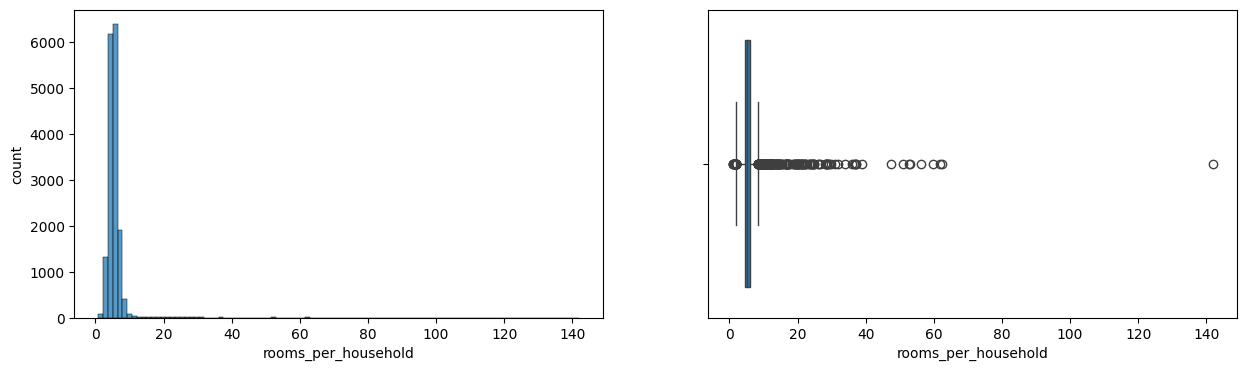

Measure of skewnesss for bedrooms_per_rooms : 2.245


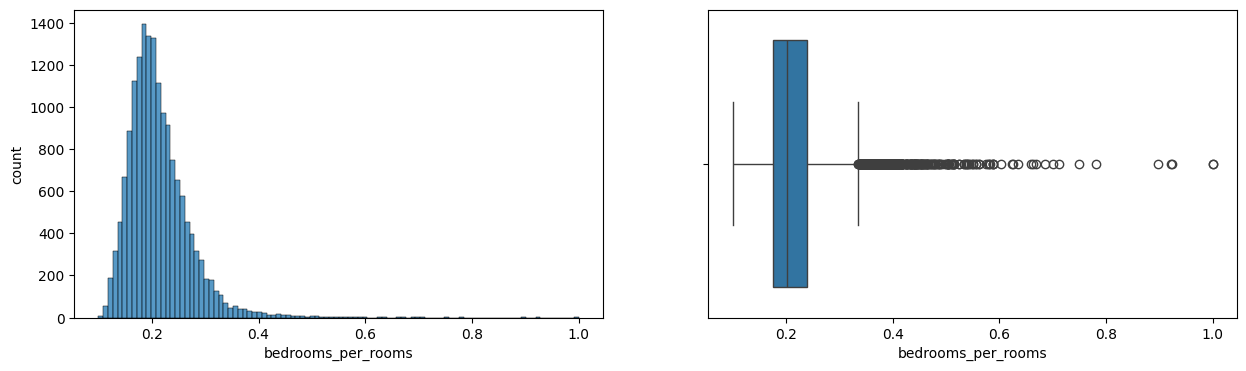

Measure of skewnesss for bedrooms_per_households : 23.171


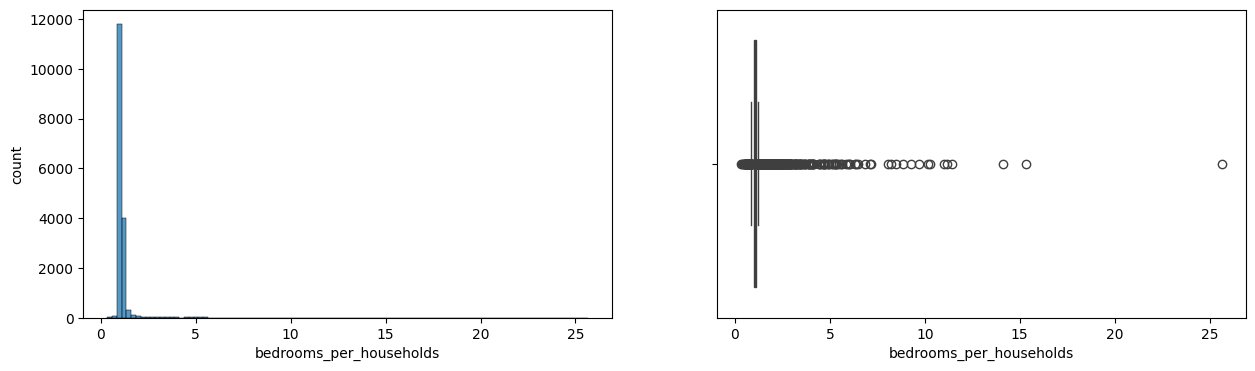

Measure of skewnesss for population_per_household : 88.053


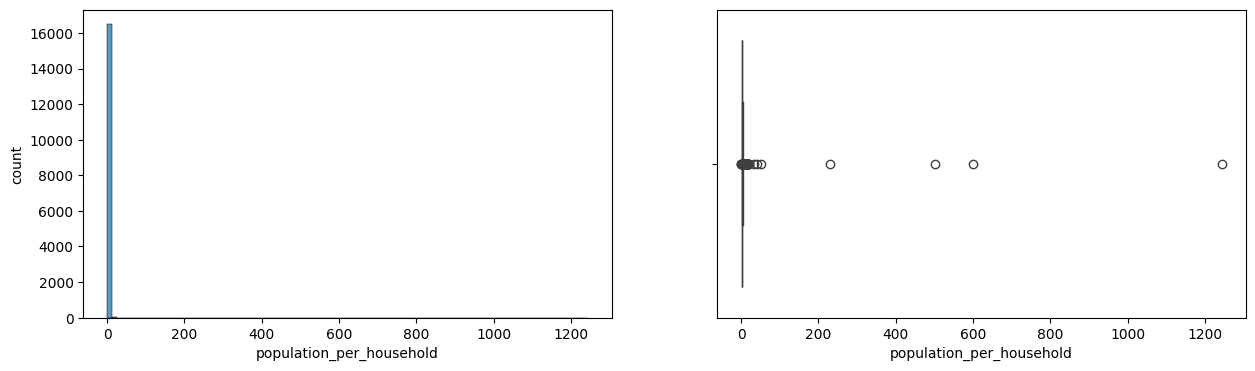

In [76]:
plot_univars(engineered_df, engineered_features, 100)

> **Observations:**
> 1. The distribution for **latitude** shows two peaks with no outliers. 
> 2. The distribution for **longitude** shows multiple peaks with no outliers. 
> 3. The distribution for **housing median age** also has mulitple peaks with no outliers.
> 4. The distribution for total number of **bedrooms** is right skewed with significant number of outliers.
> 5. The distribution for total number of **rooms** is right skewed with significant number of outliers.
> 6. The distribution for **population** in each district is right skewed with significant number of outliers.
> 7. The distribution for number of **households** in each district is right skewed with significant number of outliers.

The multiple peaks can be resolved in the one or more of the following ways:
- Transform data using log or square root function to minimize the impact of multiple peaks.
- Converting the continous features into categorical bins or ranges.
- Clustering the values using clustering algorithms or converting into separate gaussian distributions.
- Using ensembling models for handling complex data.

The skewness can be handled by introducing log, square root or quantile transformation of the skewed distribution.

<!--  -->

#### Bivariate Analysis - Interaction with Target Variable

##### Numerical Columns

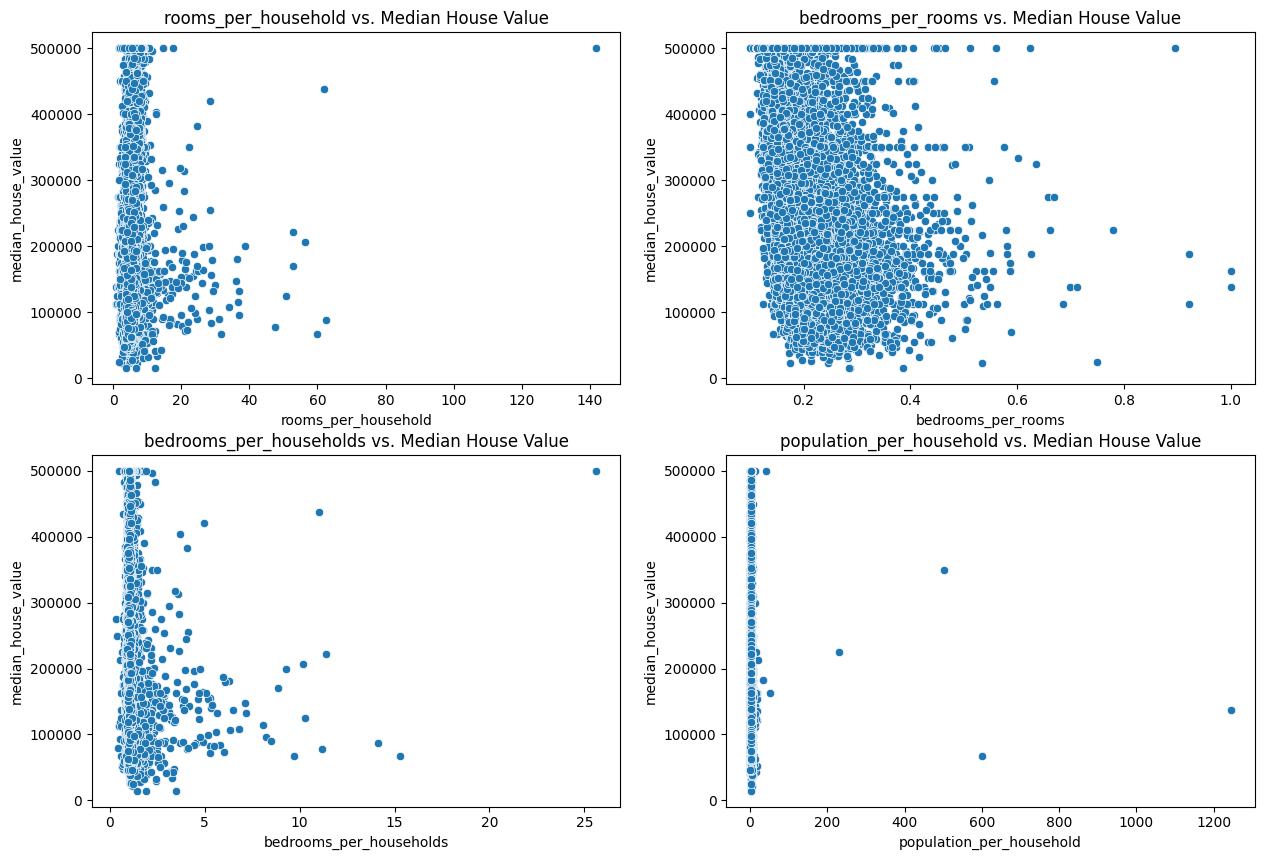

In [77]:
# Check for the relationship between the numerical columns and the target variable
plt.figure(figsize = (15, 32))
for i, feature in enumerate(engineered_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=engineered_df, x=feature, y=target)
    plt.title(f'{feature} vs. Median House Value')
plt.show()

In [81]:
corr_matrix = engineered_df.drop(columns=categorical_features, axis=1).corr()
corr_matrix[target][-4:]

rooms_per_household         0.158485
bedrooms_per_rooms         -0.257419
bedrooms_per_households    -0.051351
population_per_household   -0.022030
Name: median_house_value, dtype: float64

**Observations for feature relationship with target variable:**
1. There is no clear linear association with **longitude** or **latitude**. The values seem densly populated in around the values of -122 & -118 for longitude, and 34 & 38 for latitude.
2. There is no linear association with **median house age**. They seem independent to each other as the data points are uniformly distibuted all over the scatterplot.
3. The data points are densily located in the lower values for the following features - **total_bedrooms, total_rooms, households** and **population**. The values are the almost uniformly distributed over the target variable.
4. There is a positive linear association with **median income**.

Resolving non-linear relationships in one or more of the following ways:
- Removing irrelvant features using feature selection or engineer features.
- Cluster or binning the features that are densely populated at some values.
- Use ensemble models like bagging and boosting models to capture non-linear relationships
- Feature selection can be done through LASSO regression models or exhaustive selection algorithms.

<!--  -->

#### Mutivariate Analysis

##### Numerical features : Collinearity

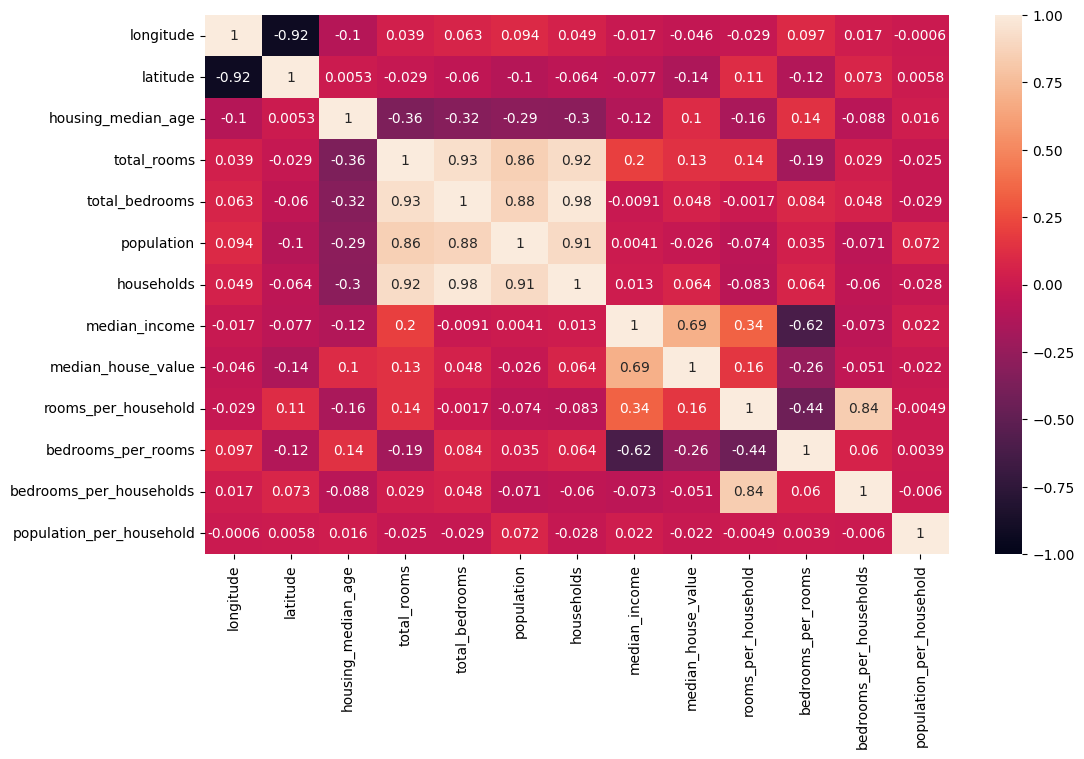

In [82]:
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1)
plt.show()

In [83]:
# Function to identify highly correlated features
def get_highly_correlated_features(corr_matrix, threshold):
    highly_correlated = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                highly_correlated.append((corr_matrix.columns[i], corr_matrix.columns[j], round(corr_matrix.iloc[i, j], 3)))
    return highly_correlated, threshold

In [84]:
# Identify highly correlated features with a threshold
highly_correlated_features, threshold = get_highly_correlated_features(corr_matrix, threshold=0.8)
multi_collineary = pd.DataFrame(highly_correlated_features,  columns=['Feature1', 'Feature2', 'Threshold'])
print(f"Highly Correlated Features with threshold value greater than {threshold}:")
print(multi_collineary)

Highly Correlated Features with threshold value greater than 0.8:
                  Feature1             Feature2  Threshold
0                 latitude            longitude     -0.924
1           total_bedrooms          total_rooms      0.930
2               population          total_rooms      0.858
3               population       total_bedrooms      0.879
4               households          total_rooms      0.920
5               households       total_bedrooms      0.980
6               households           population      0.907
7  bedrooms_per_households  rooms_per_household      0.836


> **Observations:**
> 1. The above listed feature pairs are above the listed  threshold values.

The high collinearity can be resolved in the following ways:
- Feature engineering by combining the highly correleated features.
- Reducing the dimesionality of the data and transforming features into uncorrelated features through PCA.
- use Regularization techniques like LASSO or Ridge  regression to reduce the effect of highly correlated features.
- Dropping the highly correlated features or apply feature selection.

## Data transformation

Transform all highly skewed variables.

In [91]:
log_features = ['total_bedrooms', 'total_rooms', 'population', 'households', 'rooms_per_household', "bedrooms_per_rooms", "bedrooms_per_households", "population_per_household"]

In [94]:
# Function for log transformation of the column
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()  # Create a copy to avoid altering the original data
        for colname in self.columns:
            if (X[colname] == 1.0).all():
                X[colname] = np.log(X[colname] + 1)
            else:
                X[colname] = np.log(X[colname])
        X = X.drop(self.columns, axis=1)  # Drop the original columns
        return X

In [95]:
transformer = LogTransformer(columns=log_features)
transformed_df = transformer.fit_transform(engineered_df)

#### **Understanding the data**

In [96]:
print(f'The data contains {transformed_df.shape[0]} rows and {transformed_df.shape[1]} columns')
print(f'The data contains {engineered_df.shape[1] - transformed_df.shape[1]} more columns after log transformation')

The data contains 16512 rows and 6 columns
The data contains 8 more columns after log transformation


In [ ]:
transformed_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_rooms,bedrooms_per_households,population_per_household
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,5.017657,0.200576,1.006421,3.691814
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,4.473545,0.232703,1.041005,1.738095
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,5.645833,0.174486,0.985119,2.723214
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,4.002817,0.258269,1.033803,3.994366
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,6.268421,0.180940,1.134211,2.300000


In [ ]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   ocean_proximity           16512 non-null  object 
 10  rooms_per_household       16512 non-null  float64
 11  bedrooms_per_rooms        16512 non-null  float64
 12  bedrooms_per_households   16512 non-null  float64
 13  population_per_household  16512 non-null  float64
dtypes: floa

> **Observations:**
> 1. Categorical Variables: *ocean_proximity* is the only variable of dtype 'object'
> 2. Numerical Variables: All other variables are numerical of dtype 'float64'

#### **Duplication Check**

In [ ]:
transformed_df.nunique()

longitude                     833
latitude                      845
housing_median_age             52
total_rooms                  5470
total_bedrooms               1816
population                   3639
households                   1706
median_income               10932
median_house_value           3675
ocean_proximity                 5
rooms_per_household         15671
bedrooms_per_rooms          15731
bedrooms_per_households     11949
population_per_household    15297
dtype: int64

In [ ]:
print("The Categories for ocean_proximity are:")
classes = transformed_df['ocean_proximity'].unique()
print(classes)

The Categories for ocean_proximity are:
['NEAR OCEAN' 'INLAND' '<1H OCEAN' 'NEAR BAY' 'ISLAND']


> **Observations:**
> * High amount of unique values for the numerical variables.
> * 5 categories for ocean_proximity

#### **Missing values Calculations**

In [ ]:
transformed_df.isnull().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
median_house_value          0
ocean_proximity             0
rooms_per_household         0
bedrooms_per_rooms          0
bedrooms_per_households     0
population_per_household    0
dtype: int64

> **Observation:** There are no missing values in the training data. There could be some in the testing data and should be accounted for in the preprocessing pipelines using imputation

### EDA

In [ ]:
# Separate features for easier use in analysis
numerical_features = ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'total_rooms', 'population', 'households', 'median_income', 'rooms_per_household', "bedrooms_per_rooms", "bedrooms_per_households", "population_per_household"]
categorical_features = ["ocean_proximity"]
target = "median_house_value"

#### Summary Statistics

In [ ]:
summary = transformed_df.drop(columns=[target], axis=1).describe().T
summary['range'] = summary['max'] - summary['min']
summary

,count,mean,std,min,25%,50%,75%,max,range
longitude,16512.0,-119.582290,2.005654,-124.350000,-121.810000,-118.510000,-118.010000,-114.310000,10.040000
latitude,16512.0,35.643149,2.136665,32.550000,33.930000,34.260000,37.720000,41.950000,9.400000
housing_median_age,16512.0,28.608285,12.602499,1.000000,18.000000,29.000000,37.000000,52.000000,51.000000
total_rooms,16512.0,2642.004784,2174.646744,2.000000,1454.000000,2129.000000,3160.000000,39320.000000,39318.000000
total_bedrooms,16512.0,538.496851,419.007096,1.000000,296.750000,437.000000,647.000000,6445.000000,6444.000000
population,16512.0,1426.453004,1137.056380,3.000000,789.000000,1167.000000,1726.000000,35682.000000,35679.000000
households,16512.0,499.986919,380.967964,1.000000,280.000000,410.000000,606.000000,6082.000000,6081.000000
median_income,16512.0,3.880754,1.904294,0.499900,2.566700,3.545800,4.773175,15.000100,14.500200
rooms_per_household,16512.0,5.435235,2.387375,0.888889,4.452055,5.235874,6.061037,141.909091,141.020202
bedrooms_per_rooms,16512.0,0.212858,0.057995,0.100000,0.175178,0.202808,0.239501,1.000000,0.900000


> **Observations:**
> 
> 1. On average, the **housing_median_age** in a district is ~28 with ~12 standard deviation. There potentially might be outliers.
> 2. On average, the **total rooms** in a district are ~2.6k with high standard deviation. The range shows a huge difference between min and max as max values show ~39k shows the presence of outliers. The distibution might be right skewed.
> 3. On average, the **total bedrooms** in a district  are ~0.5k with high standard deviation. The range shows a huge difference between min and max as max values show ~5k shows the presence of outliers. The distibution might be right skewed.
> 4. On average, the **households** in a district  are ~0.5k with high standard deviation. The range shows a huge difference between min and max as max values show ~6k shows the presence of outliers. The distibution might be right skewed.
> 5. On average, the **populations** in a district  are ~1.4k with high standard deviation. The range shows a huge difference between min and max as max values show ~35k shows the presence of outliers. The distibution might be right skewed.
> 6. On average, the **median_income** in a district is ~3.8 (in 10,000 USD) with ~1.9 (in 10,000 USD) standard deviation. The range shows a huge difference between min and max as max values show ~14.5 (in 10,000 USD) shows the presence of outliers. The distibution might be right skewed.

Skewed distributions and outliers can be accomodated for modelling through the following ways:
- Remove few outliers.
- Apply log transformation for getting approximately normal distribution. Be aware of zero values in the skewed features.
- Apply scaling for reducing the influence of certain features in the prediction model.

<!--  -->

#### Univariate Analysis

##### Target Variable Analysis

median_house_value Skewness: 0.977 


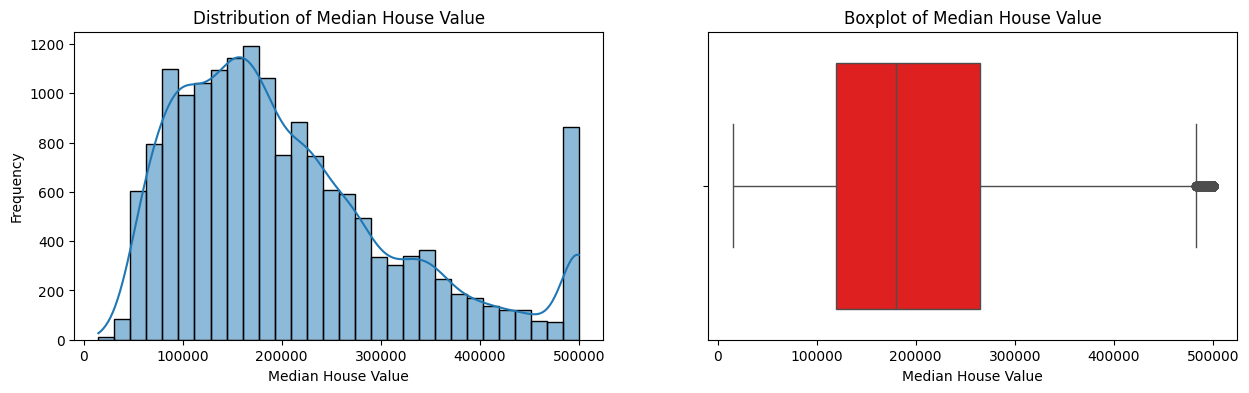

In [ ]:
print(f"{target} Skewness: {round(transformed_df[target].skew(), 3)} ")
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
sns.histplot(transformed_df[target], kde=True, bins=30)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.boxplot(x=transformed_df[target], color='red')
plt.title('Boxplot of Median House Value')
plt.xlabel('Median House Value')
plt.show()

In [ ]:
transformed_df[target].describe().T

count     16512.000000
mean     207194.693738
std      115622.626448
min       14999.000000
25%      119800.000000
50%      179850.000000
75%      265125.000000
max      500001.000000
Name: median_house_value, dtype: float64

> Observations:
> 1. The distribution is relatively normal with no skewed data.
> 2. There are over 800 districts with median house value close to 500,000 USD creating another peak. 

Increasing the performance of the model fromm the following ways:
- Either removing these values and considering them as outliers.
- Perform feature engineering for creating bins or labelling them.
- Train separate models for the outliers
- Perform log transformation to decrease the impact of the second peak on the model's performance.

<!--  -->

##### Numerical Features

In [ ]:
def plot_univars(df, num_cols, nbins):
    '''
    Plots histogram and boxplot of the counts of the variables
    
    Args:
        df (Dataframe): dataframe containing the variables
        cols (List[str]): List of string of column names to be plotted
        nbins (int): The number of bins in histogram
    
    Returns: None  
    '''
    for col in num_cols:
        print(f'Measure of skewnesss for {col} : {round(df[col].skew(), 3)}') # Calculate skewness
        plt.figure(figsize = (15, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=nbins) # Histogram for univariate counts
        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col]) # Boxplot for univariate counts
        
        plt.show()

Measure of skewnesss for longitude : -0.288


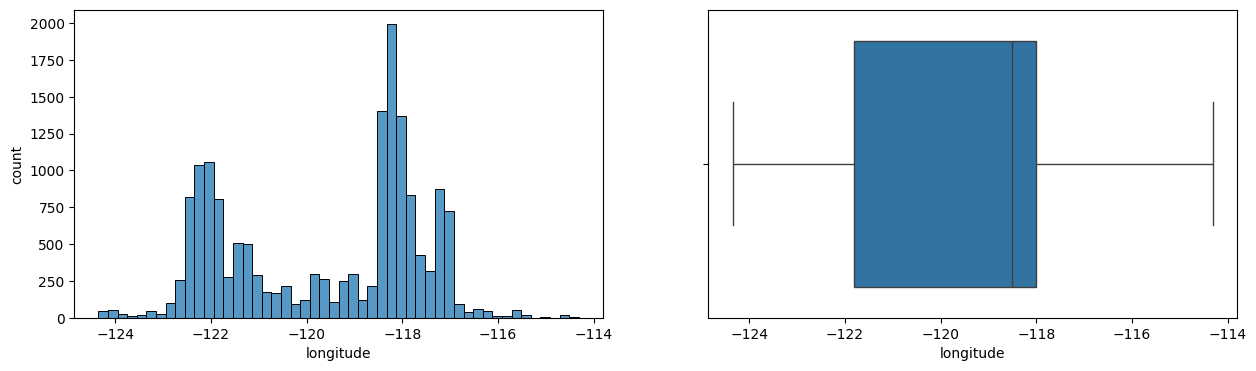

Measure of skewnesss for latitude : 0.462


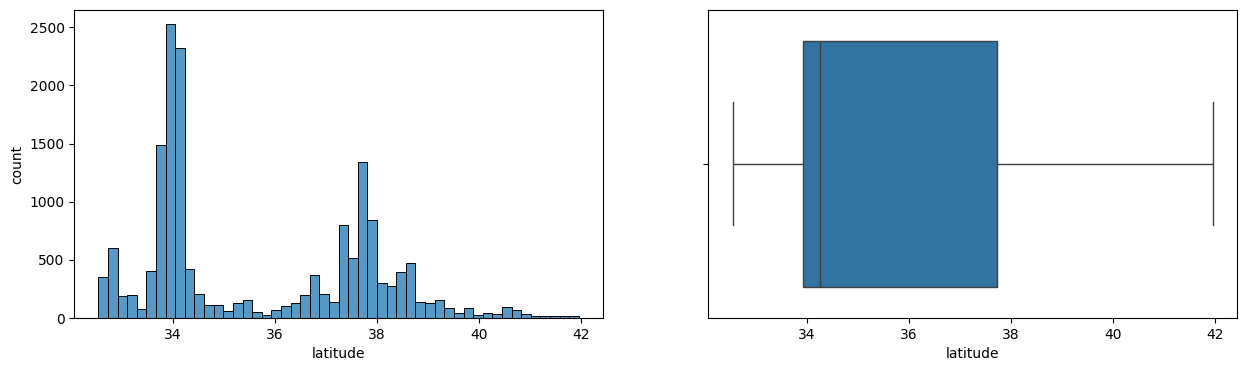

Measure of skewnesss for housing_median_age : 0.063


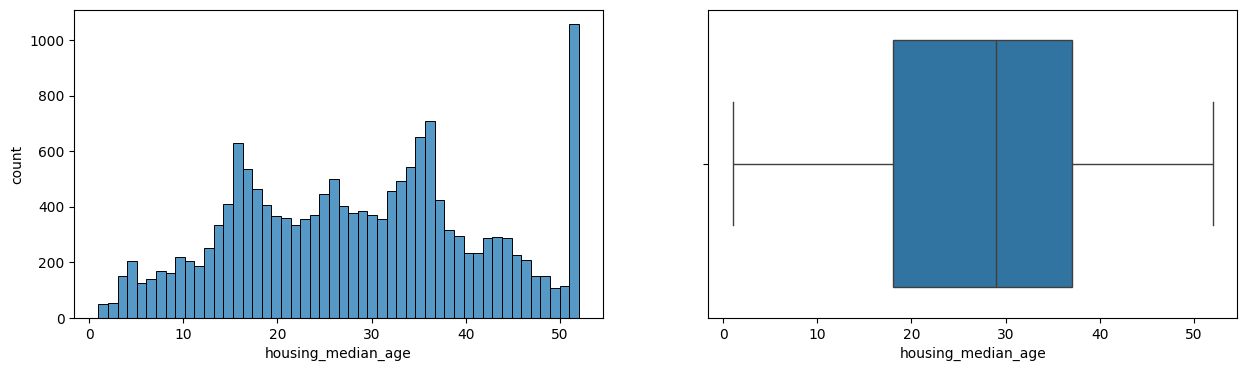

Measure of skewnesss for total_bedrooms : 3.416


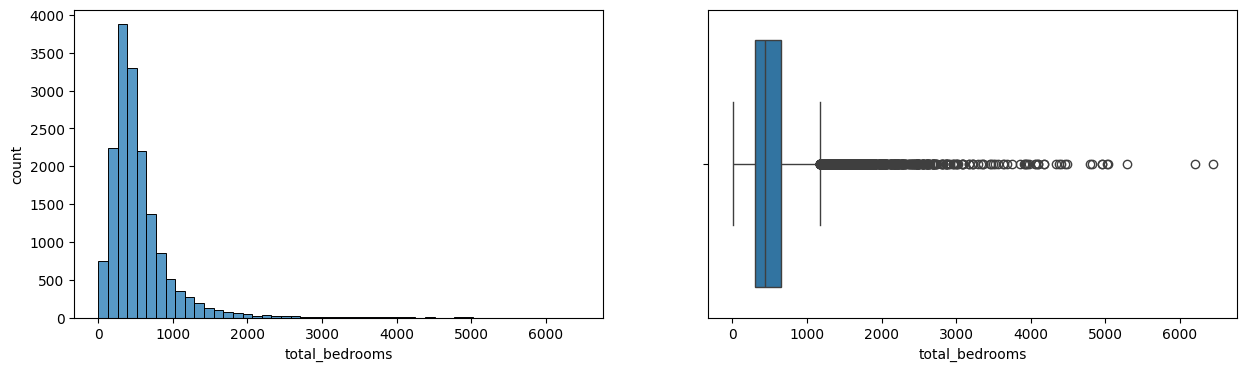

Measure of skewnesss for total_rooms : 4.091


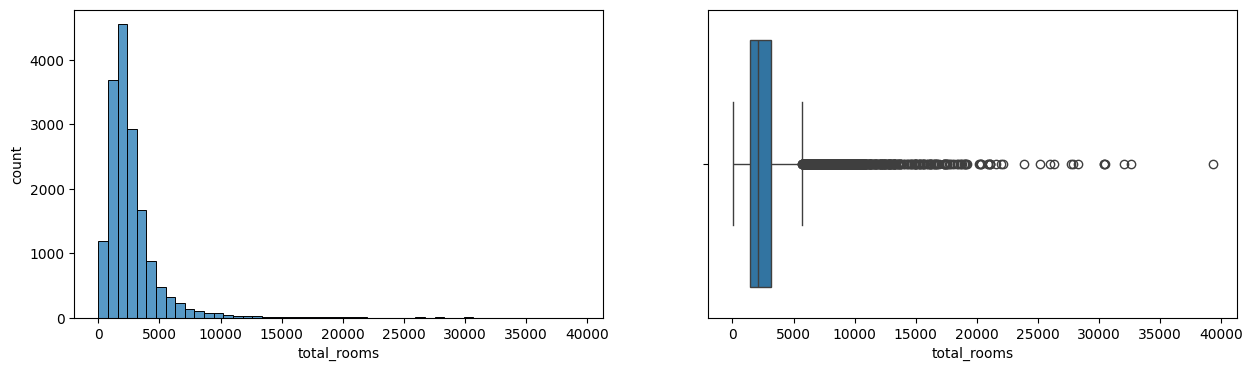

Measure of skewnesss for population : 5.276


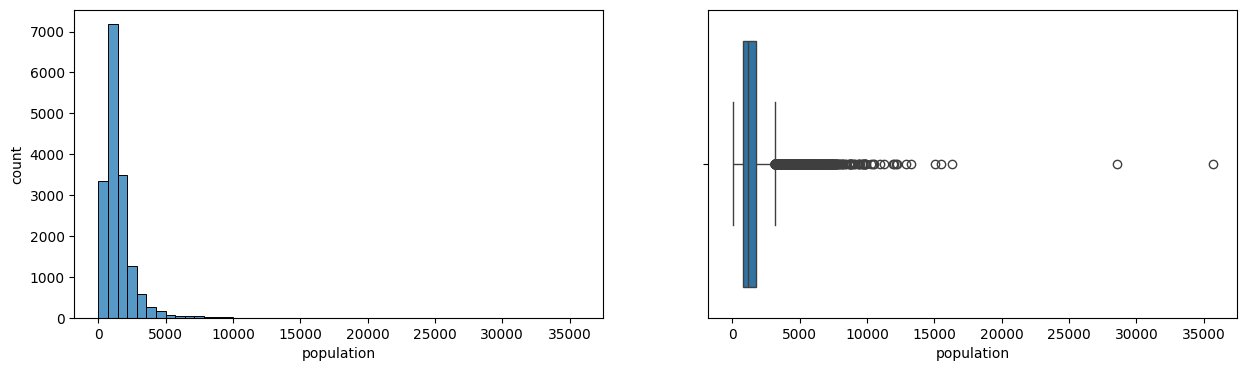

Measure of skewnesss for households : 3.387


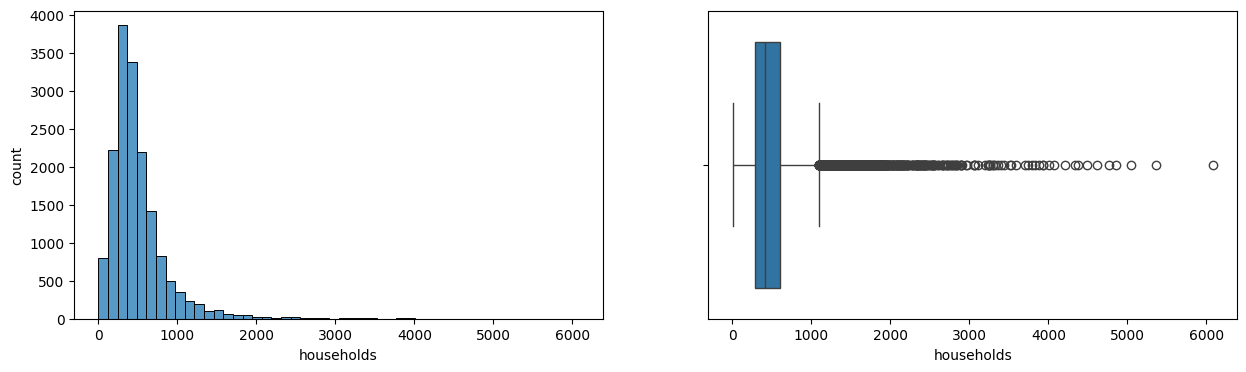

Measure of skewnesss for median_income : 1.634


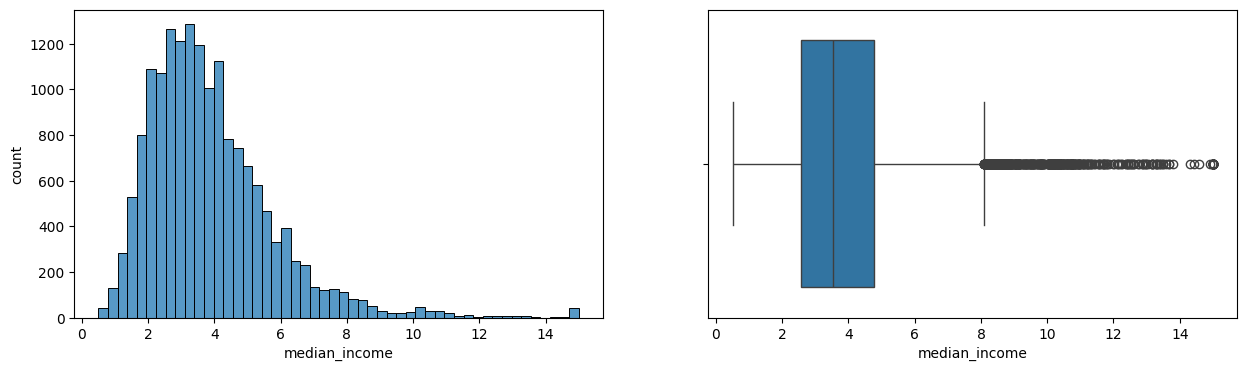

In [ ]:
plot_univars(transformed_df, numerical_features[:-4], 50)

Measure of skewnesss for rooms_per_household : 18.607


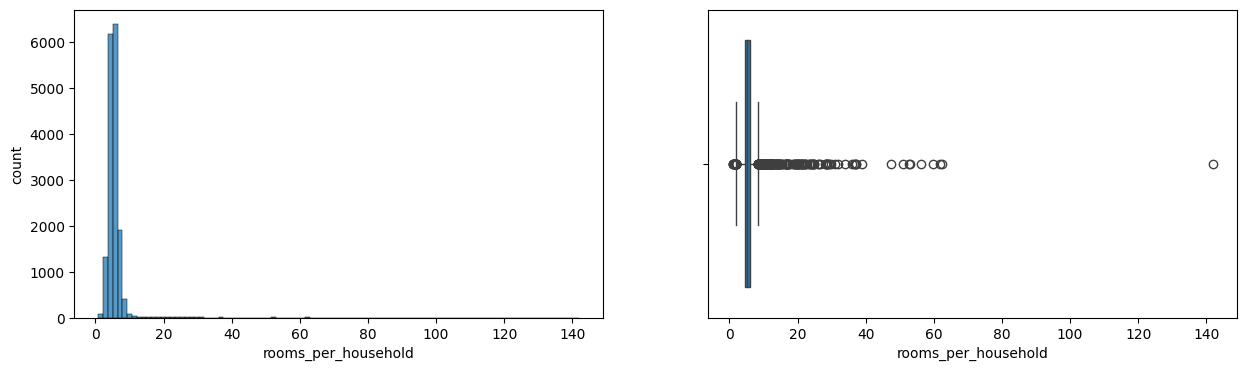

Measure of skewnesss for bedrooms_per_rooms : 2.245


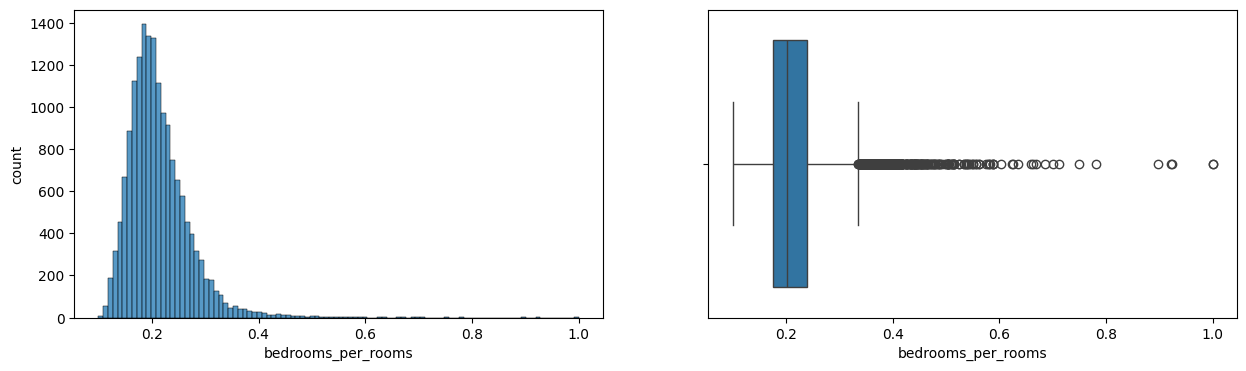

Measure of skewnesss for bedrooms_per_households : 23.171


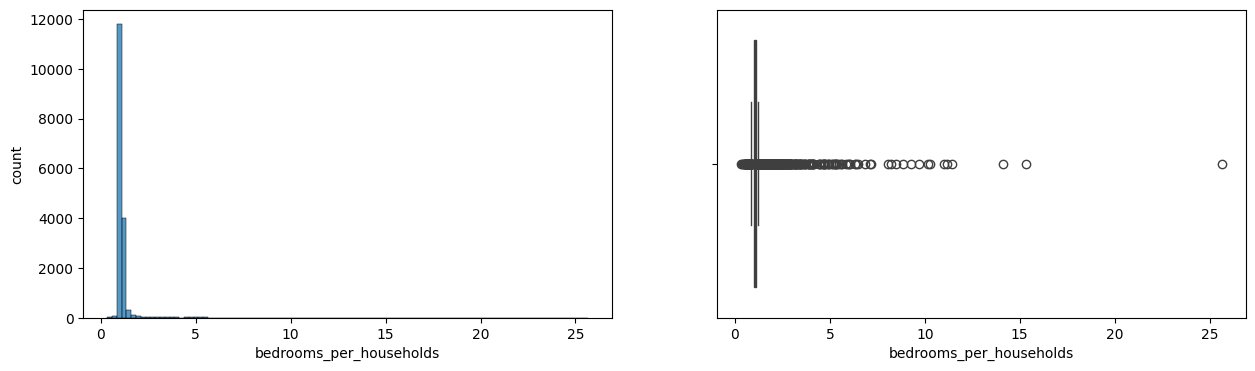

Measure of skewnesss for population_per_household : 88.053


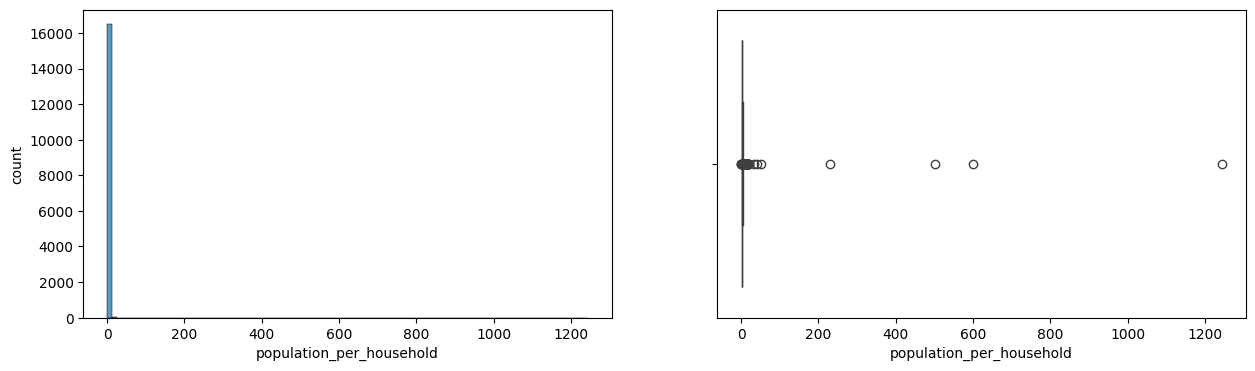

In [ ]:
plot_univars(transformed_df, numerical_features[-4:], 100)

> **Observations:**
> 1. The distribution for **latitude** shows two peaks with no outliers. 
> 2. The distribution for **longitude** shows multiple peaks with no outliers. 
> 3. The distribution for **housing median age** also has mulitple peaks with no outliers.
> 4. The distribution for total number of **bedrooms** is right skewed with significant number of outliers.
> 5. The distribution for total number of **rooms** is right skewed with significant number of outliers.
> 6. The distribution for **population** in each district is right skewed with significant number of outliers.
> 7. The distribution for number of **households** in each district is right skewed with significant number of outliers.
> 8. The distribution for the **median income** in each district is slightly right skewed with significant number of outliers.

The multiple peaks can be resolved in the one or more of the following ways:
- Transform data using log or square root function to minimize the impact of multiple peaks.
- Converting the continous features into categorical bins or ranges.
- Clustering the values using clustering algorithms or converting into separate gaussian distributions.
- Using ensembling models for handling complex data.

The skewness can be handled by introducing log, square root or quantile transformation of the skewed distribution.

<!--  -->

#### Bivariate Analysis - Interaction with Target Variable

##### Numerical Columns

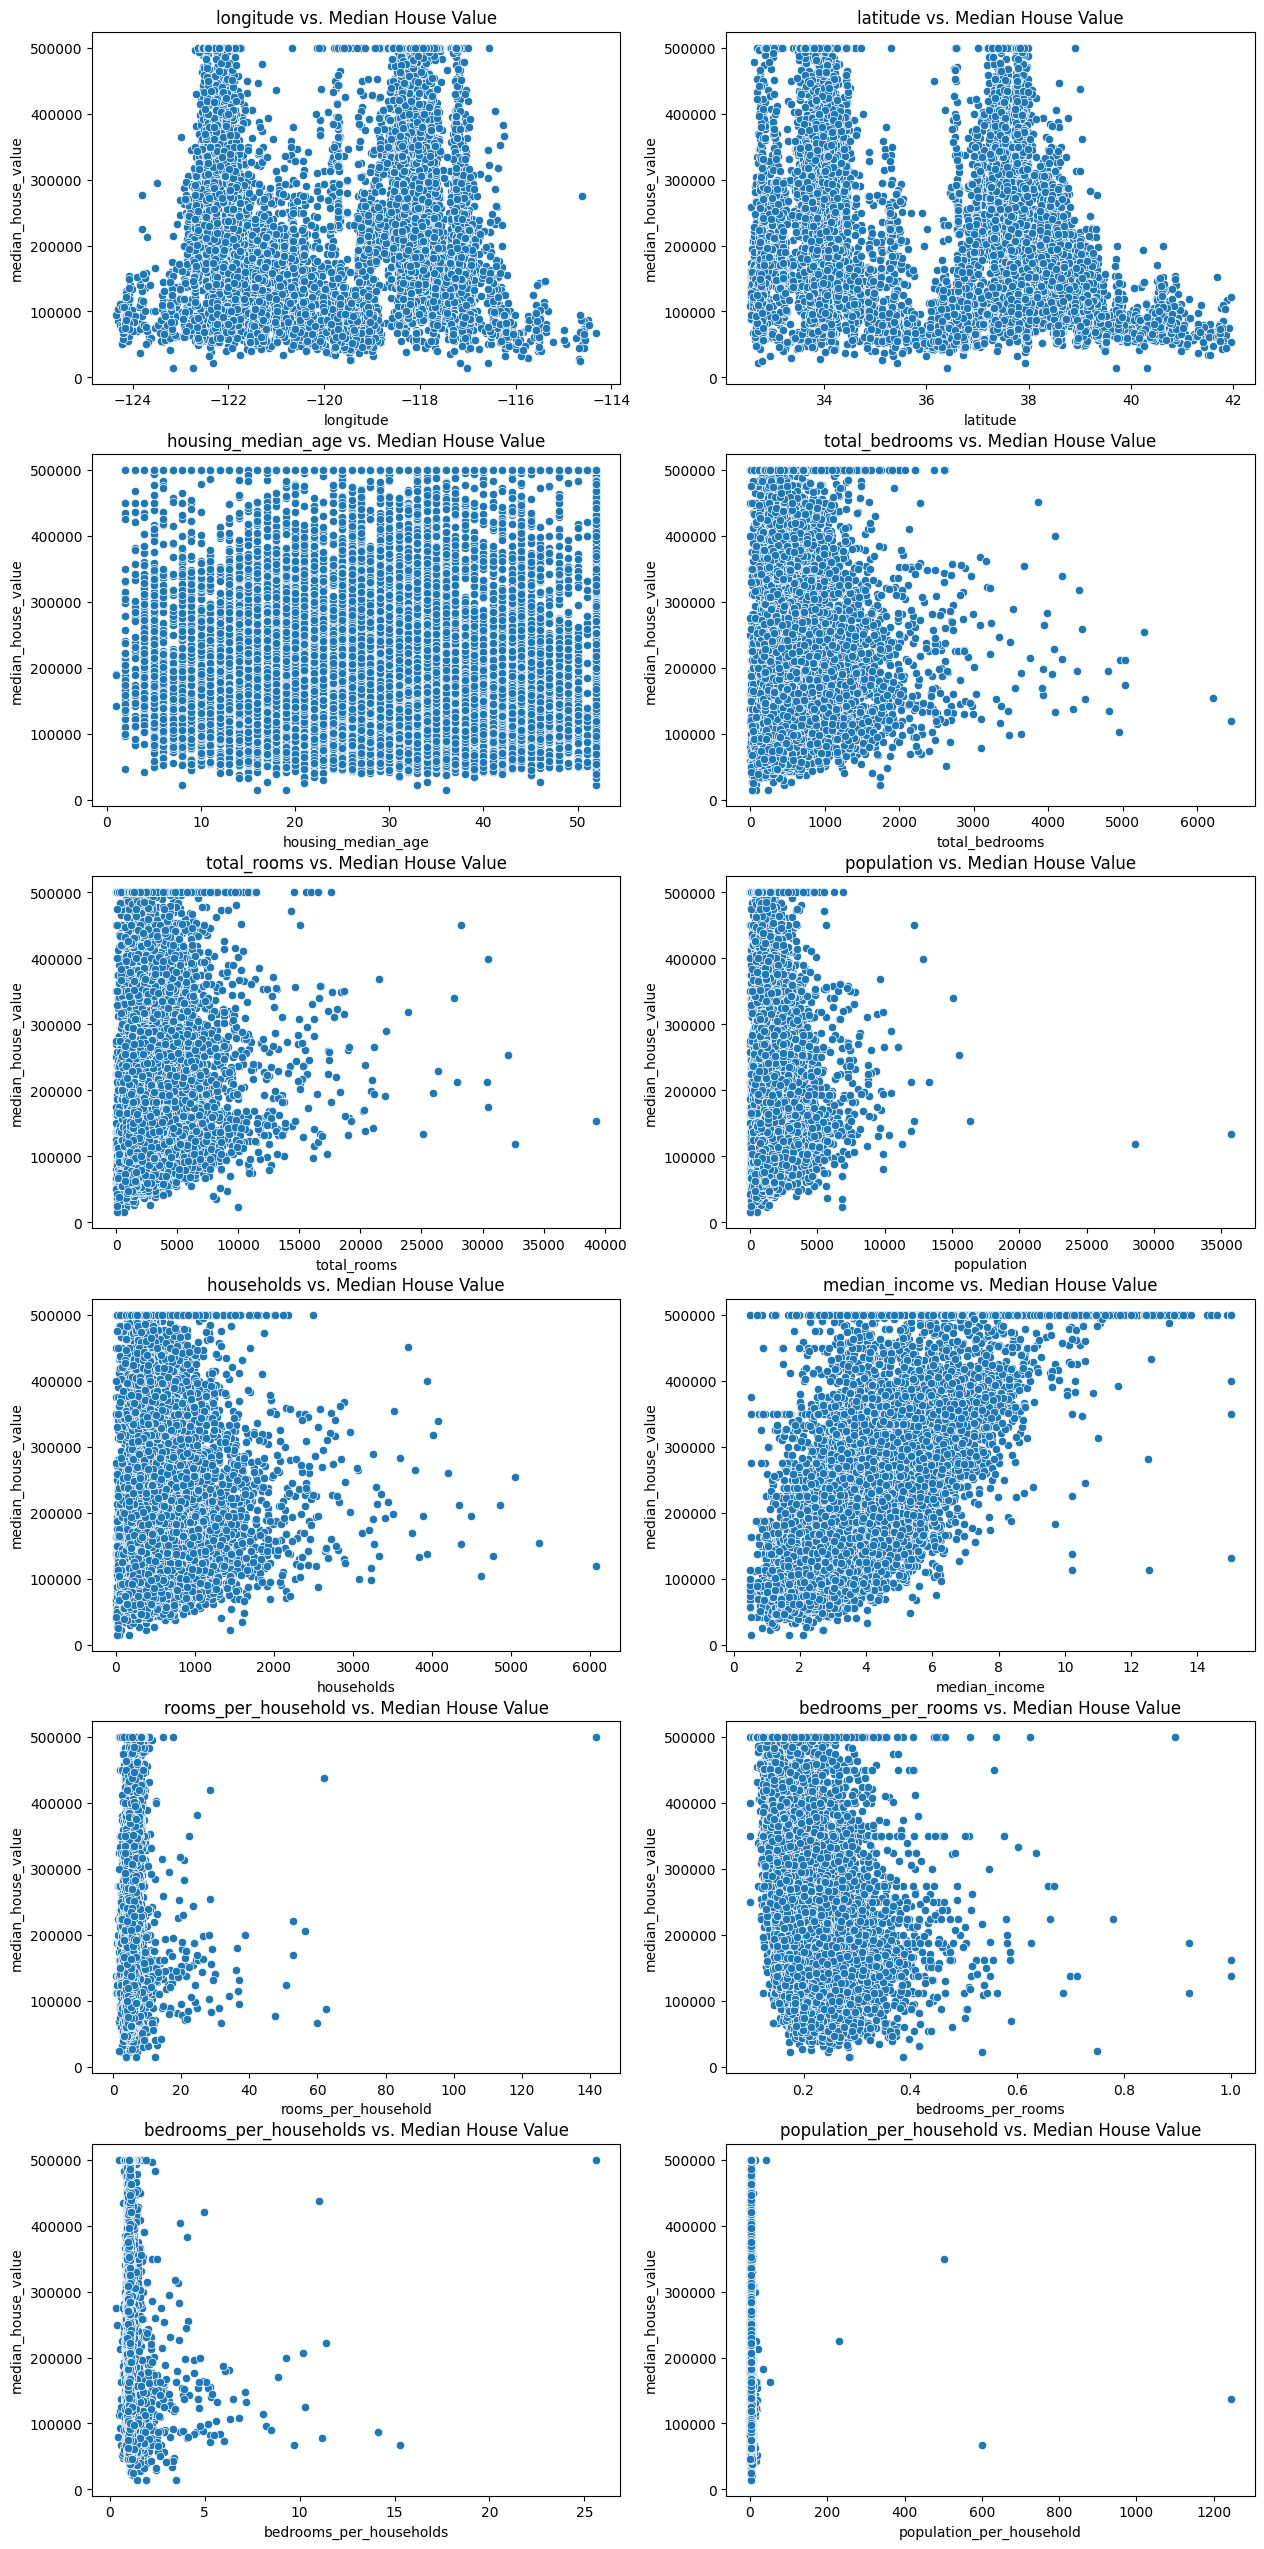

In [ ]:
# Check for the relationship between the numerical columns and the target variable
plt.figure(figsize = (15, 32))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(6, 2, i)
    sns.scatterplot(data=transformed_df, x=feature, y=target)
    plt.title(f'{feature} vs. Median House Value')
plt.show()

In [ ]:
corr_matrix = transformed_df.drop(columns=categorical_features, axis=1).corr()
corr_matrix[target]

longitude                  -0.046349
latitude                   -0.142983
housing_median_age          0.103706
total_rooms                 0.133989
total_bedrooms              0.047980
population                 -0.026032
households                  0.063714
median_income               0.690647
median_house_value          1.000000
rooms_per_household         0.158485
bedrooms_per_rooms         -0.257419
bedrooms_per_households    -0.051351
population_per_household   -0.022030
Name: median_house_value, dtype: float64

**Observations for feature relationship with target variable:**
1. There is no clear linear association with **longitude** or **latitude**. The values seem densly populated in around the values of -122 & -118 for longitude, and 34 & 38 for latitude.
2. There is no linear association with **median house age**. They seem independent to each other as the data points are uniformly distibuted all over the scatterplot.
3. The data points are densily located in the lower values for the following features - **total_bedrooms, total_rooms, households** and **population**. The values are the almost uniformly distributed over the target variable.
4. There is a positive linear association with **median income**.

Resolving non-linear relationships in one or more of the following ways:
- Removing irrelvant features using feature selection or engineer features.
- Cluster or binning the features that are densely populated at some values.
- Use ensemble models like bagging and boosting models to capture non-linear relationships
- Feature selection can be done through LASSO regression models or exhaustive selection algorithms.

<!--  -->

#### Mutivariate Analysis

##### Numerical features : Collinearity

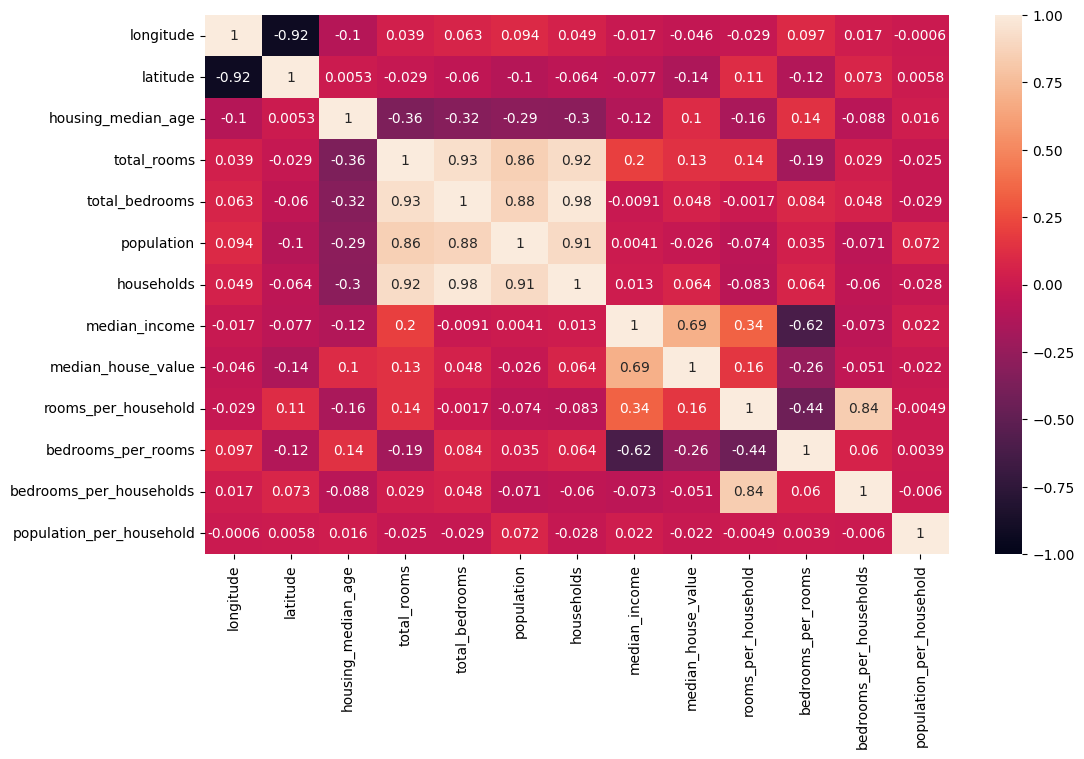

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1)
plt.show()

In [ ]:
# Function to identify highly correlated features
def get_highly_correlated_features(corr_matrix, threshold):
    highly_correlated = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                highly_correlated.append((corr_matrix.columns[i], corr_matrix.columns[j], round(corr_matrix.iloc[i, j], 3)))
    return highly_correlated, threshold

In [ ]:
# Identify highly correlated features with a threshold
highly_correlated_features, threshold = get_highly_correlated_features(corr_matrix, threshold=0.8)
multi_collineary = pd.DataFrame(highly_correlated_features,  columns=['Feature1', 'Feature2', 'Threshold'])
print(f"Highly Correlated Features with threshold value greater than {threshold}:")
print(multi_collineary)

Highly Correlated Features with threshold value greater than 0.8:
                  Feature1             Feature2  Threshold
0                 latitude            longitude     -0.924
1           total_bedrooms          total_rooms      0.930
2               population          total_rooms      0.858
3               population       total_bedrooms      0.879
4               households          total_rooms      0.920
5               households       total_bedrooms      0.980
6               households           population      0.907
7  bedrooms_per_households  rooms_per_household      0.836


> **Observations:**
> 1. The above listed feature pairs are above the listed  threshold values.

The high collinearity can be resolved in the following ways:
- Feature engineering by combining the highly correleated features.
- Reducing the dimesionality of the data and transforming features into uncorrelated features through PCA.
- use Regularization techniques like LASSO or Ridge  regression to reduce the effect of highly correlated features.
- Dropping the highly correlated features or apply feature selection.

In [ ]:
def plot_log_transformed(df, num_cols):
    for col in num_cols:
        print(col)
        print('Skew :', round(df[col].skew(), 2)) # Calculate skewness
        plt.figure(figsize = (15, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True); # Density plot for log transformed features
        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col]) # Boxplot for univariate counts
        plt.show()

bedrooms_per_households_log
Skew : 6.4


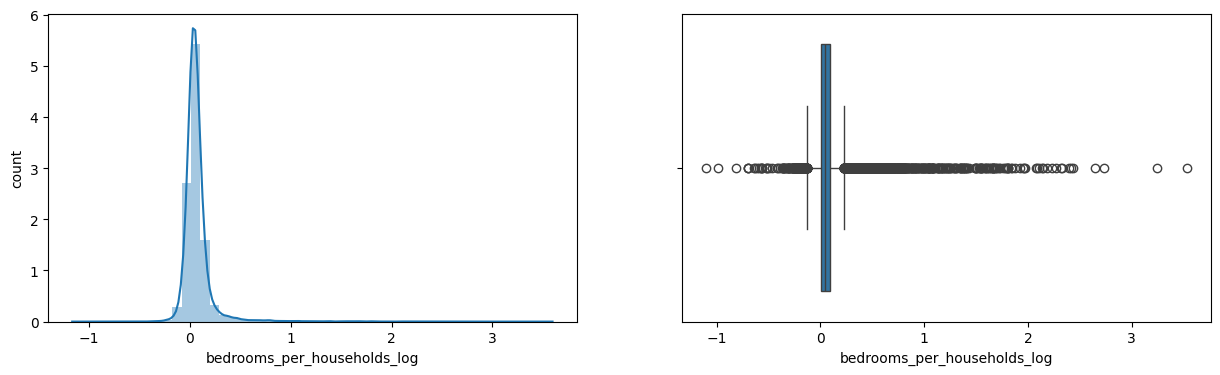

rooms_per_households_log
Skew : 0.87


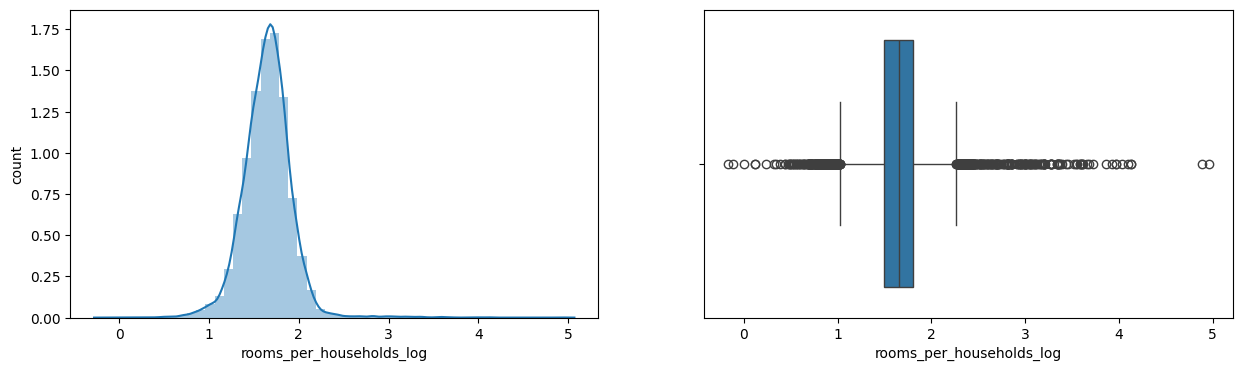

population_per_household_log
Skew : 2.13


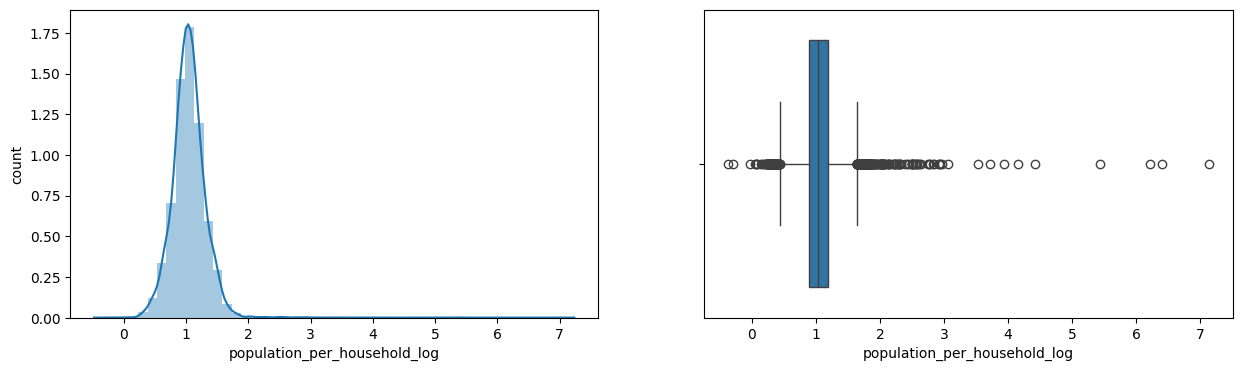

In [ ]:
plot_log_transformed(train_df, numeric_features[-3:])

## Model Building

In [ ]:
num_std_features = ['longitude', 'latitude', 'housing_median_age']
num_robust_features = ['total_rooms', 'population', 'households', 'median_income', 'rooms_per_households_log', 'population_per_household_log']
num_imp_robust_features = ['total_bedrooms', 'bedrooms_per_households_log']
cat_features = ["ocean_proximity"]
# drop_features = ["total_rooms". "total_bedrooms", "population", "households"]
target = "median_house_value"

assert set(num_std_features + num_robust_features + num_imp_robust_features + cat_features + [target]) == set(train_df.columns)

In [ ]:
# Model Selection
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

### Data Preprocessing

In [ ]:
# Preprocessing data functions and Transformers
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer

# Pipelines and Tranformers
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

In [ ]:
# Make tranformers for each feature
num_std_transformer = make_pipeline(
    StandardScaler()
)

num_robust_transformer = make_pipeline(
    RobustScaler()
)

num_imp_robust_transformer = make_pipeline(
    SimpleImputer(strategy='median', fill_value='missing'),
    RobustScaler()
)

cat_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

In [ ]:
# Make Preprocessor
preprocessor = make_column_transformer(
    (num_std_transformer, num_std_features),
    (num_robust_transformer, num_robust_features),
    (num_imp_robust_transformer, num_imp_robust_features),
    (cat_transformer, cat_features),
)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude',
                                  'housing_median_age']),
                                ('pipeline-2',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['total_rooms', 'population', 'households',
                                  'median_income', 'rooms_per_households_log',
                                  'population_per_household_log']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='median')),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['total_bedrooms',
                                  'bedrooms_per_households_log']),
                                ('pipeline-4',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['ocean_proximity'])])

In [ ]:
# Apply transformations
transformed_X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
# New Columns for OHE columns
new_cols = X_train.columns.tolist() + preprocessor.named_transformers_['pipeline-4'].get_feature_names_out().tolist()
new_cols.remove('ocean_proximity')
new_cols

NameError: name 'pd' is not defined

In [ ]:
transformed_X_train.columns = new_cols
transformed_X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedrooms_per_households_log,rooms_per_households_log,population_per_household_log,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,1.272587,-1.372811,0.348490,0.584408,1.209178,0.653374,-0.129709,-0.137986,0.899862,0.542470,-0.467912,0.0,0.0,0.0,0.0,1.0
1,0.709162,-0.876696,1.618118,0.734467,0.156884,1.061350,0.120872,-0.510032,-1.607500,0.999286,-0.088879,0.0,0.0,0.0,0.0,1.0
2,-0.447603,-0.460146,-1.952710,-0.135991,-0.268943,-0.226994,0.276686,0.244345,-0.112981,-0.302641,-0.707905,0.0,0.0,0.0,0.0,1.0
3,1.232698,-1.382172,0.586545,-0.415006,0.267876,-0.168712,-0.726634,-0.870412,1.162028,-0.199857,-0.166766,0.0,0.0,0.0,0.0,1.0
4,-0.108551,0.532084,1.142008,0.148300,-0.312700,-0.092025,0.003807,0.583410,-0.675157,-0.017131,0.873095,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.808883,-0.872016,0.507194,-0.468347,-0.543223,-0.592025,1.279960,0.510520,0.244802,-0.673804,-1.398952,1.0,0.0,0.0,0.0,0.0
16508,1.073144,-0.759688,0.348490,0.559789,0.625400,0.119632,-0.224702,0.879782,1.086061,0.379729,2.137142,0.0,1.0,0.0,0.0,0.0
16509,0.599469,-0.755007,0.586545,-0.016413,0.628602,0.358896,-0.277094,-0.883476,0.558621,0.376874,0.320513,1.0,0.0,0.0,0.0,0.0
16510,-1.185540,0.906510,-1.079841,0.847597,0.651014,0.457055,0.985010,0.648387,0.401984,0.456817,0.198095,1.0,0.0,0.0,0.0,0.0


### Model Building

In [ ]:
# @title Change Scoring Metric
scoring_metric = "neg_mean_absolute_error"
# scoring_metric = "neg_mean_squared_error"
# scoring_metric = "r2"
# scoring_metric = "neg_root_mean_squared_error"

In [ ]:
results_dict = {}  # dictionary to store all the results

In [ ]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [ ]:
# Baseline model
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True, scoring=scoring_metric
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.038 (+/- 0.008),0.011 (+/- 0.002),-91394.675 (+/- 948.272),-91390.735 (+/- 302.188)


In [ ]:
# @title Regressor Hyper-parameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression hyperparameters
linear_params = {}

# Ridge Regression hyperparameters
ridge_params = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0]
}

# Decision Tree Regression hyperparameters
dt_params = {
    'decisiontreeregressor__max_depth': [None, 5, 10],
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 4]
}

# Random Forest Regression hyperparameters
rf_params = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [None, 5, 10],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__max_features': ['sqrt', 'log2']

}

# Support Vector Regression hyperparameters
svr_params = {
    'svr__C': [0.1, 1.0, 10.0],
    "svr__gamma": [0.1, 1.0, 10],
    'svr__kernel': ['linear', 'rbf'],
    'svr__epsilon': [0.1, 0.2, 0.3]
}

# Gradient Boosting Regression hyperparameters
gb_params = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 1.0],
    'gradientboostingregressor__max_depth': [3, 5, 7],
    'gradientboostingregressor__subsample': [0.5, 0.8, 1.0]
}

# Bagging Regressor hyperparameters
bagging_params = {
    'baggingregressor__n_estimators': [10, 50, 100],
    'baggingregressor__max_samples': [0.5, 0.8, 1.0],
    'baggingregressor__max_features': [0.5, 0.8, 1.0],
    'baggingregressor__bootstrap': [True, False],
    'baggingregressor__bootstrap_features': [True, False]
}

In [ ]:
# @title Regression Pipelines
# Create the regression pipelines
linear = make_pipeline(preprocessor, LinearRegression())
ridge = make_pipeline(preprocessor, Ridge())
dt = make_pipeline(preprocessor, DecisionTreeRegressor())
rf = make_pipeline(preprocessor, RandomForestRegressor())
# svr = make_pipeline(preprocessor, SVR())
bagging = make_pipeline(preprocessor, BaggingRegressor())
gb = make_pipeline(preprocessor, GradientBoostingRegressor())

In [ ]:
# @title Grid Search Objects
# Make grid search objects
linear_GS = GridSearchCV(
    linear, linear_params, cv=5, n_jobs=-1, return_train_score=True
)
ridge_GS = GridSearchCV(
    ridge, ridge_params, cv=5, n_jobs=-1, return_train_score=True
)
dt_GS = GridSearchCV(
    dt, dt_params, cv=5, n_jobs=-1, return_train_score=True
)
rf_RS = RandomizedSearchCV(
    rf, rf_params, cv=5, n_jobs=-1, return_train_score=True, n_iter = 2
)
# svr_RS = RandomizedSearchCV(
#     svr, svr_params, cv=5, n_jobs=-1, return_train_score=True, n_iter = 1
# )
bagging_RS = RandomizedSearchCV(
    bagging, bagging_params, cv=5, n_jobs=-1, return_train_score=True, n_iter = 2
)
gb_RS = RandomizedSearchCV(
    gb, gb_params, cv=5, n_jobs=-1, return_train_score=True, n_iter = 2
)

In [ ]:
# @title Linear
# CV results for Linear
linear_relevant = [
    "mean_test_score",
    "mean_train_score",
    "mean_fit_time",
    "rank_test_score",
]
linear_GS.fit(X_train, y_train)
linear_results = pd.DataFrame(linear_GS.cv_results_)[linear_relevant].set_index("rank_test_score").sort_index()
linear_results.T

rank_test_score,1
mean_test_score,0.672875
mean_train_score,0.674086
mean_fit_time,0.069006


In [ ]:
# @title Ridge
# CV results for Ridge
ridge_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_ridge__alpha",
    "mean_fit_time",
    "rank_test_score",
]
ridge_GS.fit(X_train, y_train)
ridge_results = pd.DataFrame(ridge_GS.cv_results_)[ridge_relevant].set_index("rank_test_score").sort_index()
ridge_results.T

rank_test_score,1,2,3,4
mean_test_score,0.672888,0.672878,0.672875,0.672812
mean_train_score,0.674075,0.674086,0.674086,0.673933
param_ridge__alpha,1.0,0.1,0.01,10.0
mean_fit_time,0.061647,0.064256,0.07286,0.061004


In [ ]:
# @title DTs
# CV results for DTs
dt_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_decisiontreeregressor__max_depth",
    "param_decisiontreeregressor__min_samples_leaf",
    "param_decisiontreeregressor__min_samples_split",
    "mean_fit_time",
    "rank_test_score",
]
dt_GS.fit(X_train, y_train)
dt_results = pd.DataFrame(dt_GS.cv_results_)[dt_relevant].set_index("rank_test_score").sort_index()
dt_results.T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
mean_test_score,0.727433,0.726624,0.726531,0.721548,0.718327,0.716608,0.714502,0.713954,0.709377,0.696381,...,0.66163,0.661553,0.661277,0.660416,0.660026,0.659949,0.652157,0.648768,0.640855,0.622999
mean_train_score,0.838363,0.840039,0.840095,0.841163,0.847573,0.848689,0.842826,0.848628,0.851486,0.92444,...,0.681877,0.681877,0.681854,0.682497,0.682497,0.682497,0.970824,0.977212,0.983436,1.0
param_decisiontreeregressor__max_depth,10,10,10,10,10,10,10,10,10,None,...,5,5,5,5,5,5,None,None,None,None
param_decisiontreeregressor__min_samples_leaf,4,4,4,2,2,2,1,1,1,4,...,2,2,2,1,1,1,2,2,1,1
param_decisiontreeregressor__min_samples_split,10,2,5,10,5,2,10,5,2,10,...,5,10,2,10,2,5,5,2,5,2
mean_fit_time,0.357715,0.286311,0.357011,0.331889,0.276604,0.278702,0.714736,0.789401,0.546891,1.20356,...,0.310041,0.412059,0.35078,0.392071,0.525546,0.375732,0.635529,0.639626,1.190811,0.660096


In [ ]:
# @title RFs
# CV results for RFs
rf_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_randomforestregressor__n_estimators",
    "param_randomforestregressor__max_depth",
    "param_randomforestregressor__min_samples_leaf",
    "param_randomforestregressor__min_samples_split",
    "param_randomforestregressor__max_features",
    "mean_fit_time",
    "rank_test_score",
]
rf_RS.fit(X_train, y_train)
rf_results = pd.DataFrame(rf_RS.cv_results_)[rf_relevant].set_index("rank_test_score").sort_index()
rf_results.T

rank_test_score,1,2
mean_test_score,0.675313,0.670194
mean_train_score,0.68826,0.682949
param_randomforestregressor__n_estimators,100,100
param_randomforestregressor__max_depth,5,5
param_randomforestregressor__min_samples_leaf,1,2
param_randomforestregressor__min_samples_split,10,5
param_randomforestregressor__max_features,sqrt,log2
mean_fit_time,4.686939,3.49571


In [ ]:
# @title Bagging
# CV results for Bagging
bagging_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_baggingregressor__n_estimators",
    "param_baggingregressor__max_samples",
    "param_baggingregressor__max_features",
    "param_baggingregressor__bootstrap",
    "param_baggingregressor__bootstrap_features",
    "mean_fit_time",
    "rank_test_score",
]
bagging_RS.fit(X_train, y_train)
bagging_results = pd.DataFrame(bagging_RS.cv_results_)[bagging_relevant].set_index("rank_test_score").sort_index()
bagging_results.T

rank_test_score,1,2
mean_test_score,0.806374,0.655422
mean_train_score,0.972194,1.0
param_baggingregressor__n_estimators,50,100
param_baggingregressor__max_samples,1.0,1.0
param_baggingregressor__max_features,1.0,1.0
param_baggingregressor__bootstrap,True,False
param_baggingregressor__bootstrap_features,False,False
mean_fit_time,27.093637,79.881296


In [ ]:
# @title GB
# CV results for GBR
gb_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_gradientboostingregressor__n_estimators",
    "param_gradientboostingregressor__learning_rate",
    "param_gradientboostingregressor__max_depth",
    "param_gradientboostingregressor__subsample",
    "mean_fit_time",
    "rank_test_score",
]
gb_RS.fit(X_train, y_train)
gb_results = pd.DataFrame(gb_RS.cv_results_)[gb_relevant].set_index("rank_test_score").sort_index()
gb_results.T

rank_test_score,1,2
mean_test_score,0.829558,0.817475
mean_train_score,0.973767,0.858974
param_gradientboostingregressor__n_estimators,300,300
param_gradientboostingregressor__learning_rate,0.1,0.1
param_gradientboostingregressor__max_depth,7,3
param_gradientboostingregressor__subsample,0.5,1.0
mean_fit_time,37.299393,36.535485


In [ ]:
# @title SVR
# CV results for SVR
# svr_relevant = [
#     "mean_test_score",
#     "mean_train_score",
#     "param_svr__C",
#     "param_svr__gamma",
#     "param_svr__kernel",
#     "param_svr__epsilon",
#     "mean_fit_time",
#     "rank_test_score",
# ]
# svr_RS.fit(X_train, y_train)
# svr_results = pd.DataFrame(svr_RS.cv_results_)[svr_relevant].set_index("rank_test_score").sort_index()
# svr_results.T

In [ ]:
# @title Best Model based on R2 score with tuned hyperparameters
print(f"The best score is {linear_GS.best_score_} and the best parameters are {linear_GS.best_params_}")
print(f"The best score is {ridge_GS.best_score_} and the best parameters are {ridge_GS.best_params_}")
print(f"The best score is {dt_GS.best_score_} and the best parameters are {dt_GS.best_params_}")
print(f"The best score is {rf_RS.best_score_} and the best parameters are {rf_RS.best_params_}")
# print(f"The best score is {svr_RS.best_score_} and the best parameters are {svr_RS.best_params_}")
print(f"The best score is {bagging_RS.best_score_} and the best parameters are {bagging_RS.best_params_}")
print(f"The best score is {gb_RS.best_score_} and the best parameters are {gb_RS.best_params_}")

The best score is 0.6728747783958747 and the best parameters are {}
The best score is 0.6728876773138177 and the best parameters are {'ridge__alpha': 1.0}
The best score is 0.7274326136582998 and the best parameters are {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10}
The best score is 0.6753125060451857 and the best parameters are {'randomforestregressor__n_estimators': 100, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': 5}
The best score is 0.806374084154803 and the best parameters are {'baggingregressor__n_estimators': 50, 'baggingregressor__max_samples': 1.0, 'baggingregressor__max_features': 1.0, 'baggingregressor__bootstrap_features': False, 'baggingregressor__bootstrap': True}
The best score is 0.8295584223160486 and the best parameters are {'gradientboostingregresso

### Validate Model on Test Data

In [ ]:
# @title Transformer preprocessing and evaluating model on Test Data
X_test_transformed = preprocessor.transform(X_test)

pred_linear_GS = linear_GS.predict(X_test)
pred_ridge_GS = ridge_GS.predict(X_test)
pred_dt_GS = dt_GS.predict(X_test)
pred_rf_RS = rf_RS.predict(X_test)
pred_gb_RS = gb_RS.predict(X_test)
pred_bagging_RS = bagging_RS.predict(X_test)
# pred_svr_RS = svr_RS.predict(X_test)

In [ ]:
# @title MSE for test data
linear_mse = mean_squared_error(y_test, pred_linear_GS)
ridge_mse = mean_squared_error(y_test, pred_ridge_GS)
dt_mse = mean_squared_error(y_test, pred_dt_GS)
rf_mse = mean_squared_error(y_test, pred_rf_RS)
gb_mse = mean_squared_error(y_test, pred_gb_RS)
bagging_mse = mean_squared_error(y_test, pred_bagging_RS)
# svr_mse = mean_squared_error(y_test, pred_svr_RS)

In [ ]:
# @title R2 score on Test Data
linear_r2 = r2_score(y_test, pred_linear_GS)
ridge_r2 = r2_score(y_test, pred_ridge_GS)
dt_r2 = r2_score(y_test, pred_dt_GS)
rf_r2 = r2_score(y_test, pred_rf_RS)
gb_r2 = r2_score(y_test, pred_gb_RS)
bagging_r2 = r2_score(y_test, pred_bagging_RS)
# svr_r2 = r2_score(y_test, pred_svr_RS)

In [ ]:
# @title Default title text
print("Mean Standard Error:")
print("Linear Regression mse Score:", linear_mse)
print("Ridge Regression mse Score:", ridge_mse)
print("Decision Tree Regression mse Score:", dt_mse)
print("Random Forest Regression mse Score:", rf_mse)
print("Gradient Boosting Regression mse Score:", gb_mse)
print("Bagging Regression mse Score:", bagging_mse)
# print("Support Vector Regression mse Score:", svr_mse)
print("\n")
print("R2 Score:")
print("Linear Regression r2 Score:", linear_r2)
print("Ridge Regression r2 Score:", ridge_r2)
print("Decision Tree Regression r2 Score:", dt_r2)
print("Random Forest Regression r2 Score:", rf_r2)
print("Gradient Boosting Regression r2 Score:", gb_r2)
print("Bagging Regression r2 Score:", bagging_r2)
# print("Support Vector Regression r2 Score:", svr_r2)

Mean Standard Error:
Linear Regression mse Score: 4500404209.03565
Ridge Regression mse Score: 4501055132.435897
Decision Tree Regression mse Score: 3644832096.772991
Random Forest Regression mse Score: 4433987913.853329
Gradient Boosting Regression mse Score: 2113865934.590356
Bagging Regression mse Score: 2525915830.6545577


R2 Score:
Linear Regression r2 Score: 0.6565649134152746
Ridge Regression r2 Score: 0.6565152401139576
Decision Tree Regression r2 Score: 0.7218553781838526
Random Forest Regression r2 Score: 0.6616332772837425
Gradient Boosting Regression r2 Score: 0.8386865497954675
Bagging Regression r2 Score: 0.8072421760994525


In [ ]:
train_df, test_df = train_test_split(housing_data, test_size=0.2, random_state= 42)